## Structured Prophet Forecasting

### 🧩 Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

c:\Users\GODIWOUR\AppData\Local\anaconda\envs\stock_forecast\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 📥 Step 2: Load & Preview Data

In [2]:
# Load CSV (assuming ALX stock format with 2 headers)
file_path = '../data/AAPL.csv'  # Adjust path if needed
df = pd.read_csv(file_path, header=1)

# Drop extra header rows
df = df[df['Ticker'] != 'Date'].copy()

# Preview the raw structure
df.head()


,Ticker,AAPL,AAPL.1,AAPL.2,AAPL.3,AAPL.4
1,2020-06-17,85.442436,86.368331,85.320928,86.307577,114406400.0
2,2020-06-18,85.476456,85.894446,84.866480,85.398688,96820400.0
3,2020-06-19,84.988014,86.650252,83.877423,86.183663,264476000.0
4,2020-06-22,87.211601,87.354981,85.335508,85.381682,135445200.0
5,2020-06-23,89.073128,90.494780,88.037872,88.458294,212155600.0


### 🧹 Step 3: Clean & Prepare for Prophet

In [3]:
# Convert date column to datetime
df['Ticker'] = pd.to_datetime(df['Ticker'])

# Convert price column to numeric
df['Close'] = pd.to_numeric(df['AAPL.3'], errors='coerce')

# Keep only the needed columns
df = df[['Ticker', 'Close']].dropna()

# Rename for Prophet: ds = datetime, y = value
df.rename(columns={'Ticker': 'ds', 'Close': 'y'}, inplace=True)

# Set frequency to business days and interpolate missing
df = df.set_index('ds').asfreq('B').reset_index()
df['y'].interpolate(method='linear', inplace=True)

# Check after cleaning
df.tail()


C:\Users\GODIWOUR\AppData\Local\Temp\ipykernel_46304\733514369.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['y'].interpolate(method='linear', inplace=True)


,ds,y
1300,2025-06-11,203.500000
1301,2025-06-12,199.080002
1302,2025-06-13,199.729996
1303,2025-06-16,197.300003
1304,2025-06-17,197.199997


### ✂️ Step 4: Train/Test Split

In [4]:
# Reserve the last 30 business days as test data
train = df[:-30].copy()
test = df[-30:].copy()

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (1275, 2)
Test shape: (30, 2)


### 🔮 Step 5: Fit Prophet Model

In [5]:
# Initialize and fit model
model = Prophet()
model.fit(train)


14:59:37 - cmdstanpy - INFO - Chain [1] start processing
14:59:37 - cmdstanpy - INFO - Chain [1] done processing


### 📆 Step 6: Forecast Future Dates

In [6]:
# Forecast 30 future business days
future = model.make_future_dataframe(periods=30, freq='B')

# Generate forecast
forecast = model.predict(future)

# Preview forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1300,2025-06-11,233.209631,222.016194,243.535155
1301,2025-06-12,233.602049,222.943279,244.324653
1302,2025-06-13,233.902915,222.743602,244.239964
1303,2025-06-16,234.846912,224.311211,246.014374
1304,2025-06-17,235.640555,224.941934,246.067702


### 📊 Step 7: Plot the Forecast

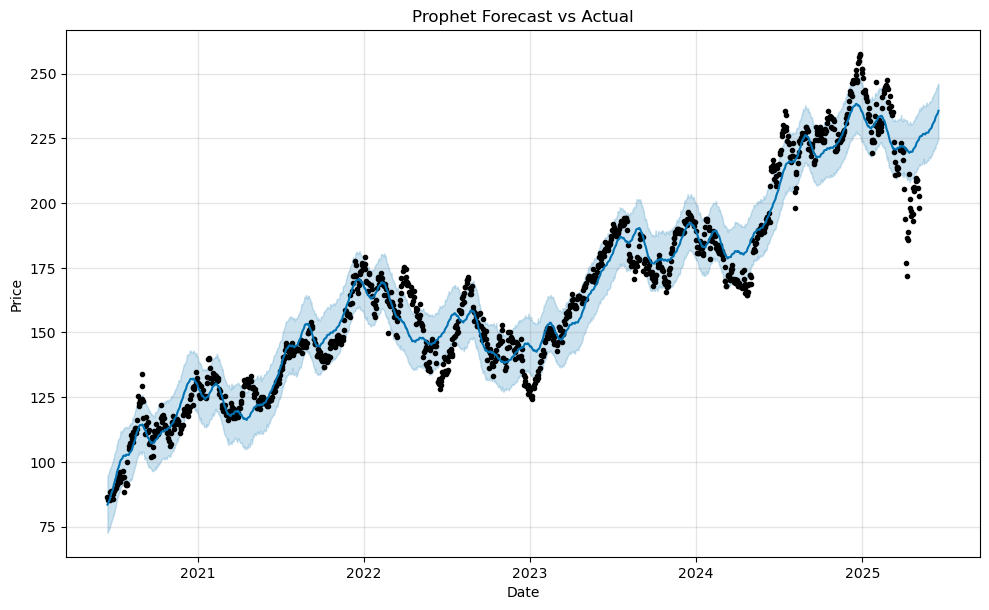

In [7]:
fig1 = model.plot(forecast)
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


### 📈 Step 8: Evaluate on Test Set

In [8]:
# Align predictions with test dates
predicted = forecast.set_index('ds').loc[test['ds'], 'yhat'].values
actual = test['y'].values

# Compute metrics
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)

print("\n📊 Evaluation for Prophet")
print("------------------------------")
print(f"MAE : {mae:.4f}")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")



📊 Evaluation for Prophet
------------------------------
MAE : 26.4194
MSE : 742.3453
RMSE: 27.2460
